## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from sklearn import metrics

%matplotlib inline

## Load the Data

In [108]:
df = pd.read_csv('final_data.csv')
df.head()

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0


In [3]:
df.shape

(10754, 22)

## Preprocess the Data

Irrelevant columns

In [110]:
#drop irrelevant columns and Remove categorical columns to include only numerical data for K-means clustering
df.drop(columns= 'player', inplace = True)
df.drop(columns= 'position_encoded', inplace = True)
df.drop(columns= 'winger', inplace = True)
df.drop(columns=['name', 'team', 'position'], inplace=True)

Outlier

In [5]:
#I won't handle outliers manually; I will try to use RobustScaler to manage them

#### 2. Feature engineering

In [111]:
# Convert scaled values back to their original scale by multiplying with 'appearance'
multiply = ['goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets']

for column in multiply:
    name = column.replace(' ', '_') + '_total'  # Generate new column name by replacing spaces with underscores and appending '_total'
    df[name] = (df[column] * df['appearance']).astype(int)  # Multiply the column values by 'appearance' and convert to integers


In [112]:
# Drop the original columns with scaled values 
df.drop(columns=['goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets'], inplace=True)

In [9]:
df.shape

(10754, 16)

In [10]:
df.columns

Index(['height', 'age', 'appearance', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value',
       'goals_total', 'assists_total', 'yellow_cards_total',
       'second_yellow_cards_total', 'red_cards_total', 'goals_conceded_total',
       'clean_sheets_total'],
      dtype='object')

#### 3. Feature selection

**Select features that capture a meaningful differences between the data points**

In [113]:
selected_features = ["appearance", 'current_value', 'age'] #These features represent economic value, participation level, and career stage, providing a well-rounded view of the players’ profiles

# Create a new DataFrame containing the selected features based on meaning
df_with_meaning = df[selected_features]

# Display the first few rows of the new DataFrame
df_with_meaning.head()

,appearance,current_value,age
0,104,15000000,32.0
1,15,1500000,30.0
2,4,600000,37.0
3,82,50000000,25.0
4,63,40000000,30.0


3. Select features based on PCA

**Use PCA to reduce the high dimensionality of the data**

In [178]:
# First, we need to scale the data because PCA is sensitive to the scale of the features
scaler = RobustScaler() # sacle the data using RobustScaler
X_scaled = scaler.fit_transform(df)
meaning_scaled = scaler.fit_transform(df_with_meaning) 

In [179]:
# Apply Principal Component Analysis (PCA) 
pca = PCA(n_components = 3)  # Initialize PCA to reduce to 3 dimensions
pca.fit(X_scaled)
PCA_scaled = pca.transform(X_scaled)  # Fit PCA and transform the scaled features


In [180]:
#generate a DataFrame where rows are principal components and columns are original features, showing the contribution of each feature to each principal component

# Extract the principal component loadings from  PCA 
components = pca.components_

# Get the feature names from the DataFrame 
feature_names = df.columns  

# Create a DataFrame to display the principal component loadings
components_df = pd.DataFrame(components, columns=feature_names, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Print the principal components (loadings) DataFrame
print("Principal Components (loadings):")
print(components_df)


Principal Components (loadings):
       height       age  appearance  minutes played  days_injured  \
PC1  0.013616  0.005106    0.004137        0.009190     -0.000138   
PC2  0.005937  0.010607    0.061222        0.063817      0.044837   
PC3  0.004128  0.105148    0.000173        0.002570      0.102982   

     games_injured     award  current_value  highest_value  goals_total  \
PC1      -0.000547  0.005009       0.000203       0.002111    -0.014042   
PC2       0.054408  0.207677       0.716034       0.626869     0.146701   
PC3       0.115526  0.430859      -0.254722       0.105875    -0.033593   

     assists_total  yellow_cards_total  second_yellow_cards_total  \
PC1      -0.011548           -0.006717                  -0.001797   
PC2       0.116555            0.048382                   0.005476   
PC3      -0.026563           -0.009139                  -0.001049   

     red_cards_total  goals_conceded_total  clean_sheets_total  
PC1        -0.000828              0.977808     

1. **PC1**: Primarily reflects **defensive performance**, with `goals_conceded_total` being the most significant contributor (0.977808).

2. **PC2**: Represents **player recognition and market value**, highlighted by `current_value` (0.716034) and `award` (0.207677).

3. **PC3**: Indicates a mix of **defensive metrics and player experience**, with `clean_sheets_total` (0.818379) being a key factor.

In [181]:
# Convert PCA results to DataFrame
df_with_PCA = pd.DataFrame(PCA_scaled, columns=['PC1', 'PC2', 'PC3'])

### K Distances

**k-Distance for Meaning Data**

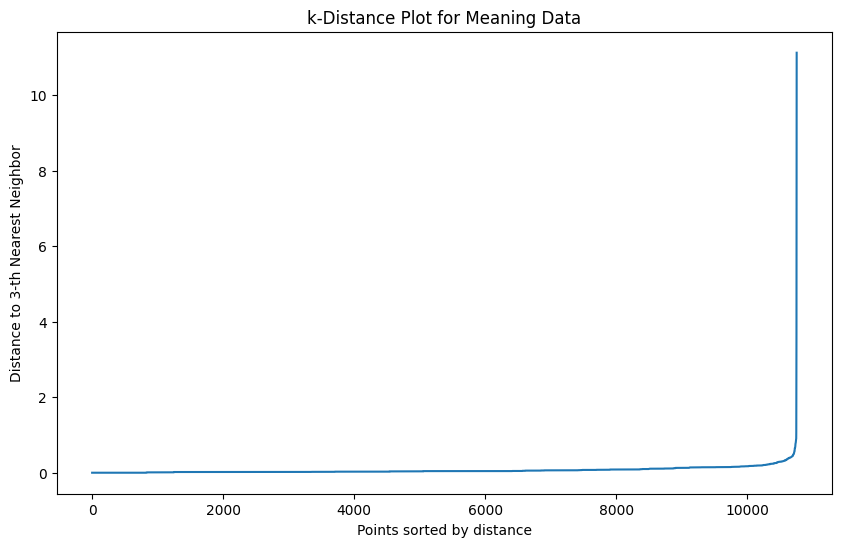

In [154]:
# Set the number of neighbors for the NearestNeighbors model
k = 3  

# Initialize the NearestNeighbors model with k neighbors
neighbors = NearestNeighbors(n_neighbors=k)

# Fit the NearestNeighbors model to the scaled meaning data
neighbors_fit = neighbors.fit(meaning_scaled)

# Compute distances to the k-th nearest neighbor for each point
distances, indices = neighbors_fit.kneighbors(meaning_scaled)

# Sort the distances to the k-th nearest neighbor in ascending order
k_distances = np.sort(distances[:, k-1])

# Plot the k-distance graph to help determine the optimal 'eps' for DBSCAN
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.plot(k_distances)  # Plot the sorted distances to the k-th nearest neighbor
plt.title('k-Distance Plot for Meaning Data')  # Set the title of the plot
plt.xlabel('Points sorted by distance')  # Label for the x-axis
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')  # Label for the y-axis
plt.show()  # Display the plot


**k-Distance for PCA Data**

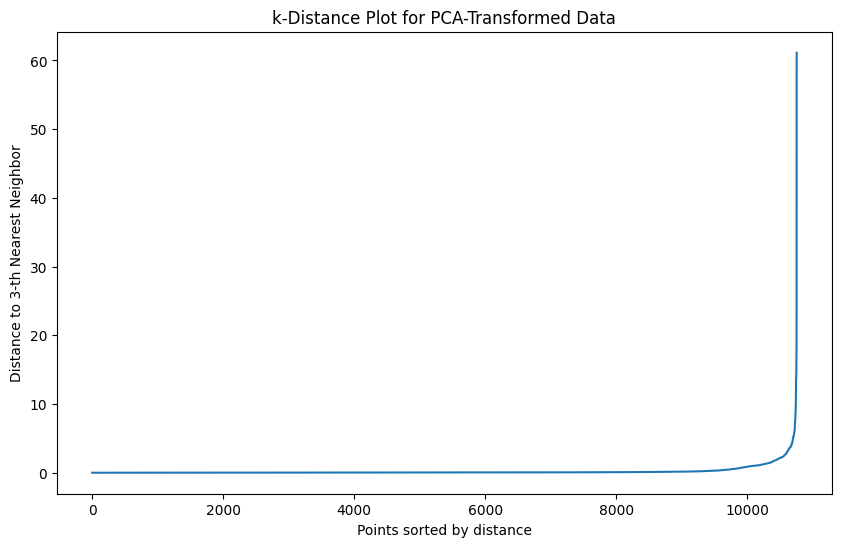

In [128]:
# Set the number of neighbors for the NearestNeighbors model
k = 3  
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(PCA_scaled)
distances, indices = neighbors_fit.kneighbors(PCA_scaled)

# Sort the distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, k-1])

# Plot the k-distance graph to find the elbow point
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title('k-Distance Plot for PCA-Transformed Data')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.show()


After trying eps = 0.4, eps = 0.5 , eps = o.7 and eps = 1

I will uses eps = 0.7

# Model 1

## Buliding the Model

In [208]:
k = 3
optimal_eps = 0.7
model_meaning =DBSCAN(eps = optimal_eps, min_samples =k)
model_PCA = DBSCAN(eps = optimal_eps, min_samples =k)

## Train and Test the Model

In [209]:
# Fit the meaning model
DBSCAN_meaning = model_meaning.fit_predict(meaning_scaled)

# Fit the PCA model
DBSCAN_PCA = model_PCA.fit_predict(PCA_scaled)

## Evaluating the Model 

**Add Cluster column**

In [210]:
df_with_meaning['Cluster'] = DBSCAN_meaning
df_with_meaning.head()

,appearance,current_value,age,Cluster
0,104,15000000,32.0,0
1,15,1500000,30.0,0
2,4,600000,37.0,0
3,82,50000000,25.0,1
4,63,40000000,30.0,2


In [211]:
df_with_meaning['Cluster'].value_counts()

Cluster
 0     10502
 11       47
 3        38
 2        24
 1        17
 14       16
 8        14
-1        14
 9        14
 7        14
 5        10
 6         9
 4         8
 10        7
 13        6
 12        4
 17        4
 15        3
 16        3
Name: count, dtype: int64

In [212]:
df_with_PCA['Cluster'] = DBSCAN_PCA
df_with_PCA.head()

,PC1,PC2,PC3,Cluster
0,126.738612,13.137719,8.257916,-1
1,14.616568,1.421250,0.136661,-1
2,-1.037900,-0.552550,3.672146,-1
3,-3.608304,19.222855,-1.813833,-1
4,-3.525395,21.822229,2.705592,-1


In [213]:
df_with_PCA['Cluster'].value_counts()

Cluster
 0     9542
-1      801
 13      29
 8       26
 17      25
 16      24
 38      18
 40      16
 18      16
 20      14
 3       13
 42      12
 31      12
 1       10
 35      10
 34       9
 24       9
 6        9
 43       8
 33       8
 27       7
 4        6
 54       5
 30       5
 47       5
 15       5
 5        5
 12       5
 21       5
 9        5
 50       4
 45       4
 41       4
 39       4
 28       4
 25       4
 32       3
 44       3
 51       3
 11       3
 37       3
 46       3
 48       3
 49       3
 55       3
 56       3
 14       3
 10       3
 52       3
 7        3
 26       3
 23       3
 2        3
 36       3
 29       3
 22       3
 19       3
 53       3
Name: count, dtype: int64

**Silhouette_score**

In [162]:
from sklearn.metrics import silhouette_score

# Evaluate the quality of clusters
silhouette_meaning = silhouette_score(meaning_scaled, model_meaning.labels_)
silhouette_PCA = silhouette_score(PCA_scaled, model_PCA.labels_)

print(f'Silhouette Score for Meaning Model: {silhouette_meaning}')
print(f'Silhouette Score for PCA Model: {silhouette_PCA}')


Silhouette Score for Meaning Model: 0.7678701946132774
Silhouette Score for PCA Model: -0.17385689052243614


- **Meaning Model** has a high Silhouette Score (0.77), indicating good clustering.
- **PCA Model** has a negative Silhouette Score (-0.17), indicating poor clustering.

While the Meaning Model excels in compactness, the PCA Model provides superior cluster separation


In [164]:
from sklearn.metrics import davies_bouldin_score


# Davies-Bouldin Index for df_with_meaning
db_index_meaning = davies_bouldin_score(df_with_meaning, DBSCAN_meaning)
print(f'Davies-Bouldin Index for Meaning Data: {db_index_meaning}')

# Davies-Bouldin Index for df_with_PCA
db_index_PCA = davies_bouldin_score(df_with_PCA, DBSCAN_PCA)
print(f'Davies-Bouldin Index for PCA Data: {db_index_PCA}')


Davies-Bouldin Index for Meaning Data: 32.38787195042345
Davies-Bouldin Index for PCA Data: 0.7981167074466465


The **PCA Data** has a lower Davies-Bouldin Index (0.80), indicating better clustering quality than the **Meaning Data**, which has a high index (32.39)..

#### For now **Meaning model** is better than **PCA model**

**Visualize the results of KMeans**

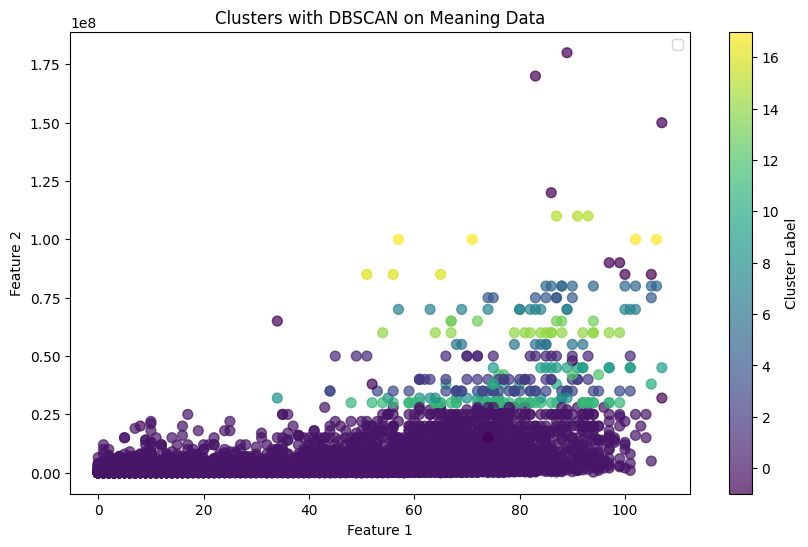

In [175]:
# Extract the first two columns for plotting
X1 = df_with_meaning.iloc[:, 0].values
X2 = df_with_meaning.iloc[:, 1].values

# Plot the data points, color-coded by cluster assignments
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X1, X2, c=DBSCAN_meaning, cmap='viridis', marker='o', s=50, alpha=0.7)


# Add plot title and labels
plt.title('Clusters with DBSCAN on Meaning Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Add legend and color bar, and show the plot
plt.legend()
plt.colorbar(scatter, label='Cluster Label')
plt.show()


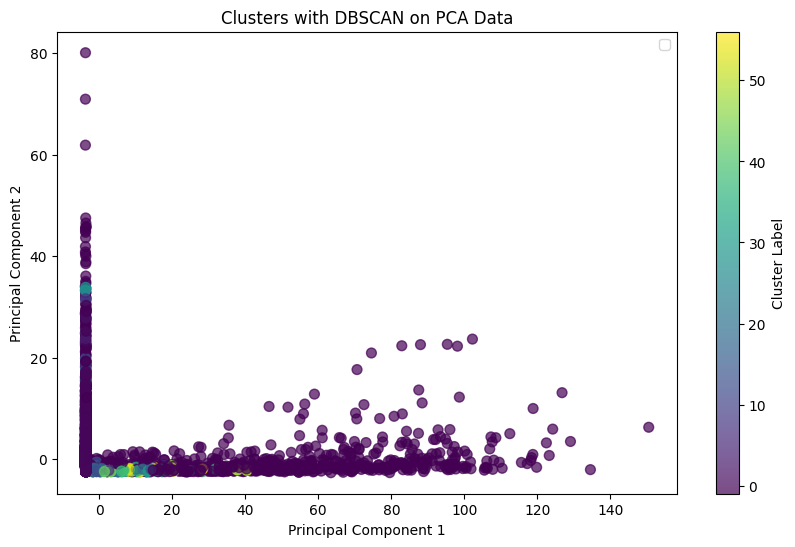

In [176]:
# Extract the first two principal components for plotting
X1 = df_with_PCA.iloc[:, 0].values
X2 = df_with_PCA.iloc[:, 1].values

# Plot the data points, color-coded by cluster assignments
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X1, X2, c=DBSCAN_PCA, cmap='viridis', marker='o', s=50, alpha=0.7)

# Add plot title and labels
plt.title('Clusters with DBSCAN on PCA Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend and color bar, and show the plot
plt.legend()
plt.colorbar(scatter, label='Cluster Label')
plt.show()


# Model 2

**Using hierarchical clustering on the PCA data could enhance the clustering results. Hierarchical clustering might better capture the structure in the PCA-reduced space, potentially improving the overall clustering quality**

In [182]:
# Apply Agglomerative Clustering to the PCA-transformed data
hierarchical = AgglomerativeClustering(n_clusters=3)  # Initialize AgglomerativeClustering with 3 clusters
labels_hierarchical = hierarchical.fit_predict(PCA_scaled)  # Fit the model to the scaled PCA data and predict cluster labels


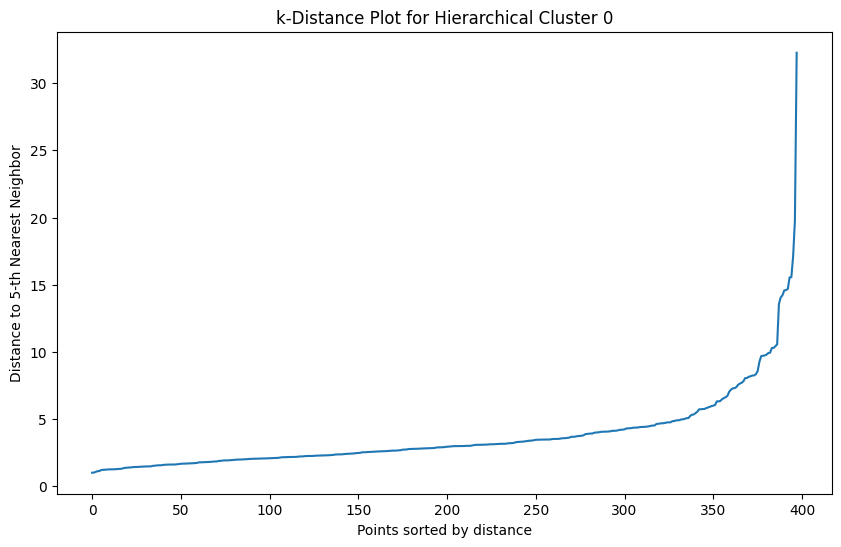

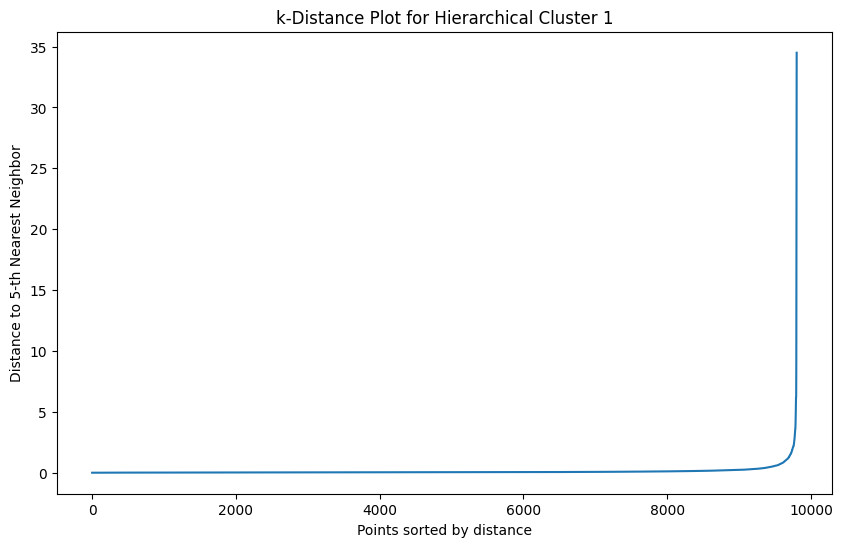

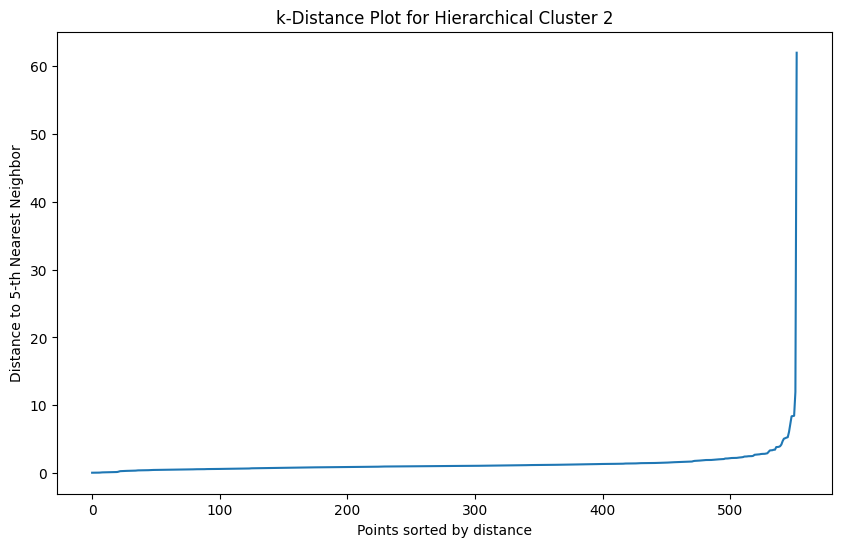

In [183]:
# Initialize an array to store the final labels, starting with the hierarchical cluster labels
final_labels_train = np.copy(labels_hierarchical)

# Loop through each unique hierarchical cluster ID
for cluster_id in np.unique(labels_hierarchical):
    # Extract the data points that belong to the current hierarchical cluster
    cluster_data = PCA_scaled[labels_hierarchical == cluster_id]

    # Determine the optimal 'eps' value for DBSCAN by analyzing distance to k-th nearest neighbor
    k = 5  # Number of neighbors to use for distance computation
    neighbors = NearestNeighbors(n_neighbors=k)  # Initialize NearestNeighbors with k neighbors
    neighbors_fit = neighbors.fit(cluster_data)  # Fit the model on the cluster data
    distances, indices = neighbors_fit.kneighbors(cluster_data)  # Compute distances to the k-th nearest neighbors

    # Sort the distances to the k-th nearest neighbor in ascending order
    k_distances = np.sort(distances[:, k-1])

    # Plot the k-distance graph to identify the optimal 'eps' value for DBSCAN
    plt.figure(figsize=(10, 6))  # Set the figure size for the plot
    plt.plot(k_distances)  # Plot the sorted k-distances
    plt.title(f'k-Distance Plot for Hierarchical Cluster {cluster_id}')  # Set the title of the plot
    plt.xlabel('Points sorted by distance')  # Label for the x-axis
    plt.ylabel(f'Distance to {k}-th Nearest Neighbor')  # Label for the y-axis
    plt.show()  # Display the plot


In [200]:
# Define the parameters for DBSCAN clustering
optimal_eps = 1  # Set the maximum distance between two samples for them to be considered as in the same neighborhood
k = 5 # Minimum number of samples required to form a dense region (core point)

# Initialize DBSCAN with the specified parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=k)

# Fit DBSCAN to the cluster data and predict the cluster labels
dbscan_labels = dbscan.fit_predict(cluster_data)

In [201]:
# Update the final labels with the DBSCAN results
final_labels_train[labels_hierarchical == cluster_id] = dbscan_labels

In [202]:
# Update the final labels with the results from DBSCAN
# For each hierarchical cluster, replace the cluster data labels with the new DBSCAN labels
final_labels_train[labels_hierarchical == cluster_id] = dbscan_labels

In [203]:
hierarchical_silhouette = silhouette_score(PCA_scaled, labels_hierarchical)
print(f'Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.2f}')

# Evaluate Final DBSCAN Clustering
if len(set(final_labels_train)) > 1:  # Ensure there's more than one cluster
    dbscan_silhouette = silhouette_score(PCA_scaled, final_labels_train)
    print(f'Final DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
else:
    print('Final DBSCAN resulted in a single cluster or noise only.')

Hierarchical Clustering Silhouette Score: 0.78
Final DBSCAN Silhouette Score: 0.66


In [204]:
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin Index for Hierarchical Clustering
# This index measures the average similarity ratio of each cluster with its most similar cluster.
davies_bouldin_hierarchical = davies_bouldin_score(PCA_scaled, labels_hierarchical)
print(f'Davies-Bouldin Index (Hierarchical): {davies_bouldin_hierarchical:.2f}')

# Calculate the Davies-Bouldin Index for the final DBSCAN Clustering
# This is done only if more than one cluster is found by DBSCAN to avoid invalid results.
if len(set(final_labels_train)) > 1:
    davies_bouldin_dbscan = davies_bouldin_score(PCA_scaled, final_labels_train)
    print(f'Davies-Bouldin Index (DBSCAN): {davies_bouldin_dbscan:.2f}')
else:
    # If DBSCAN resulted in only one cluster or all data points are labeled as noise
    print('Final DBSCAN resulted in a single cluster or noise only.')


Davies-Bouldin Index (Hierarchical): 0.65
Davies-Bouldin Index (DBSCAN): 2.06


#### This is the best model